# CNN Computer Vision Plant Seedling Image Classification

# Charles Kilpatrick


##  Background and Context

Agriculture has a great need to modernize to reduce the amount of manual labor required for checking if the growth of seedling plants is satisactory. Despite technical advances, agricultural industry workers still need the ability to recognize and distinguish between crop seedlings and weeds, with a minimal amount of time required.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor.  The time and energy required to identify plant seedlings  will be greatly shortened by the use of AI and Deep Learning. The ability to classify seedlings far more efficiently and more effectively than experienced manual labor may lead to better crop yields. Human involvement can be freed up for higher-order agricultural decision making, and in the long term more sustainable environmental practices in agriculture can be implemented.



## Objective

The objective is to build a Convolutional Neural Network model which will classify plant seedlings into their respective 12 categories. The input data of images of unique plants belonging to 12 different species was provided by the Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark.

## Data Description
This dataset contains images of unique plants belonging to 12 different species.
The data file names are:

images.npy
Label.csv

The images were converted to numpy arrays and stored in an images.npy file and the corresponding labels are in the file Labels.csv to facilitate working on the data/project seamlessly.
The goal of the project is to create a classifier capable of determining a

## Data Dictionary

List of plant species:
* Small-flowered Cranesbill
* Fat Hen
* Shepherds Purse
* Common wheat
* Common Chickweed
* Charlock
* Cleavers
* Scentless Mayweed
* Sugar beet
* Maize
* Black-grass
* Loose Silky-bent

### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2


# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")




In [2]:
import tensorflow as tf

# Get the list of available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    # If a GPU is available, use it
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device = "/GPU:0"
    print("Using GPU")
else:
    # If no GPU is available, use CPU
    device = "/CPU:0"
    print("Using CPU")

Using GPU


### Loading Dataset

In [4]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [6]:
# Load local copies of the image file of the dataset
#images = np.load('images.npy')

# Load the labels file of the dataset
#labels = pd.read_csv('Labels.csv')

## Exploratory Data Analysis

### Data Overview

In [7]:
# Print images shape
print(images.shape)

(4750, 128, 128, 3)


* The dataset has a total of 4750,  128 x 128 pixel, 3 channel images

In [8]:
# Print the shape of the target
print(labels.shape)

(4750, 1)


In [9]:
# Check for null and missing labels
labels.isnull().sum()

Label    0
dtype: int64

In [10]:
# Determine distribution of target value
count = labels.value_counts(ascending = True)
print(count)
print('*'*10)
count = labels.value_counts(normalize = True, ascending = True)
print(count)

Label                    
Common wheat                 221
Maize                        221
Shepherds Purse              231
Black-grass                  263
Cleavers                     287
Sugar beet                   385
Charlock                     390
Fat Hen                      475
Small-flowered Cranesbill    496
Scentless Mayweed            516
Common Chickweed             611
Loose Silky-bent             654
dtype: int64
**********
Label                    
Common wheat                 0.046526
Maize                        0.046526
Shepherds Purse              0.048632
Black-grass                  0.055368
Cleavers                     0.060421
Sugar beet                   0.081053
Charlock                     0.082105
Fat Hen                      0.100000
Small-flowered Cranesbill    0.104421
Scentless Mayweed            0.108632
Common Chickweed             0.128632
Loose Silky-bent             0.137684
dtype: float64


### Comments On Imbalanced Data Distribution

* The following plant species under represented:
* Common wheat (4.7%)
* Maize (4.7%)
* Shepherds Purse (4.9%)
* Black-grass (5.5%)

* The data frequency for following plant species is appropriate for a dataset with 12 categories:
* Sugar beet (8.1%)
* Charlock (8.2%)

* The following plant species are overrepresented in the dataset:
* Fat Hen (10.0%)
* Small-flowered Cranesbill (10.4%)
* Scentless Mayweed (10.9%)
* Common Chickweed (12.9%)
* Loose Silky-bent (13.8%)


* Class weights will be calculated and and then used to compensate for data imbalance during the model fitting step.



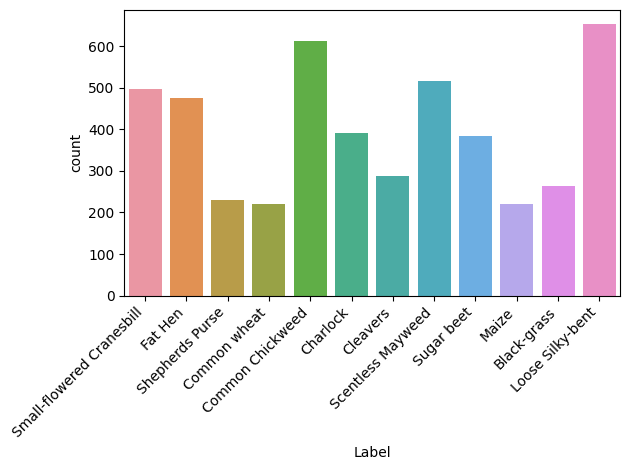

In [11]:
# Plot a countplot of the dataset species
ax = sns.countplot(labels['Label'], x=labels['Label'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

### Comments On Countplot Of Plant Species In Dataset

* The countplot provides a visual representation of the data species in the dataset.  
* As commented above There is significant imbalance in the species representaion in the dataset and class weights will be calculated and implemented.

* The following species are underrepresented:
* Common wheat
* Maize
* Shepherds Purse
* Black grass

* The following plant species are represented in a proper proportion for a dataset with 12 categories:

* Sugar beet
* Charlock

* The following plant species are overepresented in the dataset:
* Fat Hen
* Small- flowered Cranesbill
* Scentless Mayweed
* Common Chickweed
* Loose Silky-bent

### Print Images Before Modifications

In [12]:
# Store an image index for each species for consistent comparisons in the study
species = ["Small-flowered Cranesbill", "Fat Hen", "Shepherds Purse", "Common wheat", "Common Chickweed", "Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]
img_indx = []

# Iterate through the species and record an image index

for j in range(0, len(species)):
   for i in range(0, len(images)):
      if (labels.Label[i] == species[j]):
         img_indx.append(i)
         j+1
         break


In [13]:
print(img_indx)

[0, 496, 971, 1202, 1423, 2034, 2424, 2711, 3227, 3612, 3833, 4096]


In [14]:
# Define function for plotting images

def plot_images(images, labels):
  cnt = 0
  keys = dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10,8))
  for i in range(cols):
      for j in range(rows):
          indx = img_indx[cnt]
          cnt = cnt +1
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[indx, :])
          ax.set_title(keys[indx])
plt.show()

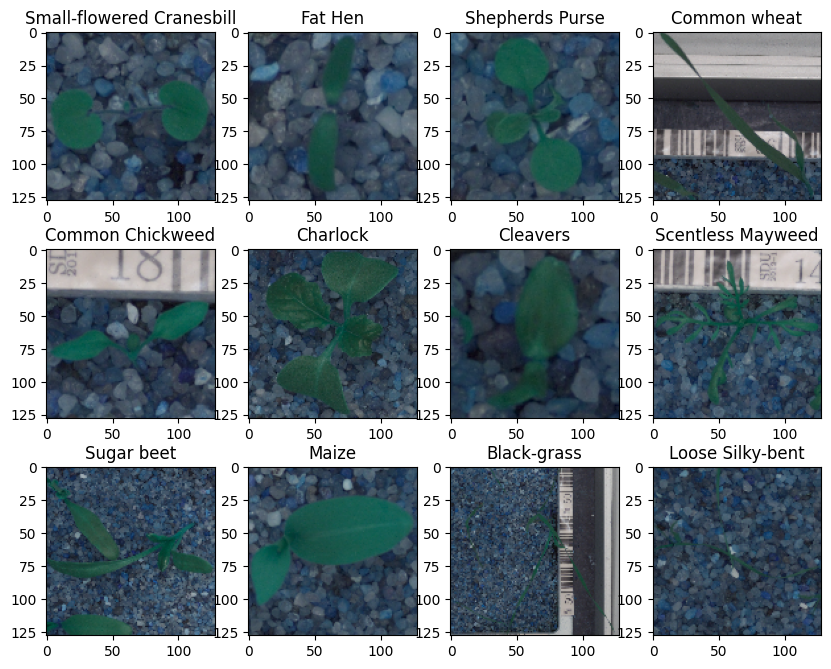

In [15]:
# Plot one image of each of the plant species before any image processing
plot_images(images,labels)

### Comments On Images Before Modifications
* Note that a plant cannot be distinguished in the Black-grass image. Additional Black-grass images were also printed and it was not unusual to observe a grainy image similar to what is presented above.
* Note that the Loose Silky-bent image is very poor quality as well. Additional Loose Silky-bent images were also printed and it was not unusual to observe a grainy image similar to what is presented above.

### Key Observations From Exploratory Data Analysis

* The dataset contains 4750 images of shape 128 x 128 pixels with 3 channels

* The following species are underrepresented in the dataset: Common wheat, Maize, Shepherds Purse, and Black-grass.

* The following species are represented appropriately for a population with 12 categories:  Sugar beet, Charlock.

* The following species are overrepresented in the dataset: Fat Hen, Small-flowered Cranebill, Scentless Mayweed, Common Chickweed, Loose Silky-bent.

* Class weights will be used to minimize mis-classification of the species with greater representation to a category with lesser representation.

* A number of Black grass images were viewed and the images were of poor clarity this could result in mis-classification concerns.

* A number of Loose Silky-bent images were determined to be of poor clarity which may result in classification concerns.






## Data Pre-Processing




### Image Color Format Check - Plot the same image using OpenCV and Matplotlib

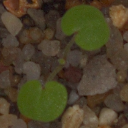

In [16]:
# Check color format by plotting a Small-flowered Cranesbill image using OpenCV
cv2_imshow(images[5])

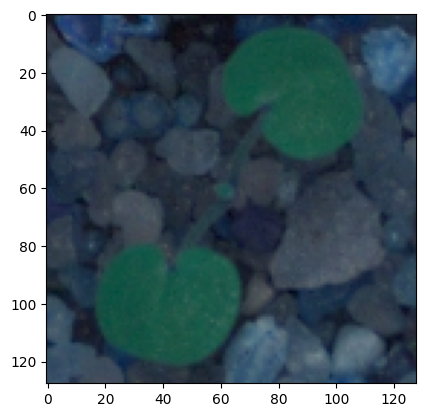

In [17]:
# Check color format by plotting same Small-flowered Cranesbill image using Matplotlib
plt.imshow(images[5])

### Comment On Image Color Comparison

* Images show different colors when plotted with openCV and matplotlib.
* OpenCV uses BGR format and the numpy arrays were generated using OpenCV.
* The BGR images will be converted to RGB images for easier interpretation.

In [18]:
# Convert the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

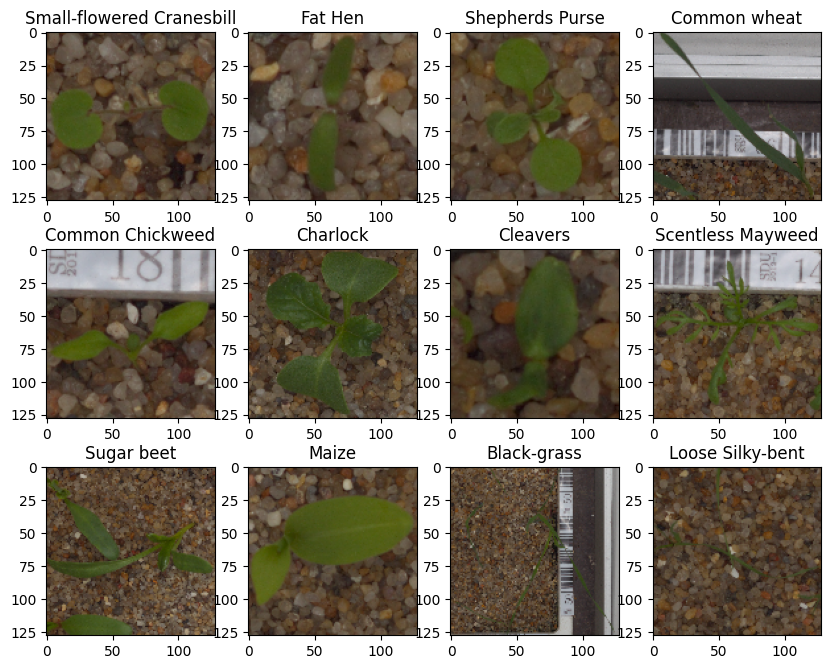

In [19]:
# Plot A Consistent Set Of Plant Images Post BGR to RGB Conversion
plot_images(images,labels)

### Comments On Images After Conversion To RGB
* Overall the images are more clear after conversion to RGB.
* The Black-grass image still does not show a clear plant image. Additional Black-grass images were also printed and it was not unusual to observe an image very similar to what is presented above.
* The Loose Silky-bent image still does not show a clear plant image. Additional Loose Silky-bent images were also printed and it was not unusual to observe an image very similar to what is presented above.

### Implement Gaussian Deblurring

In [20]:
# Implement gaussion blurring to denoise images.  Setting sigmaX to 0 results in sigmaX and sigmaY being calculated based on 3x3 kernel
# Both a 3x3 and 5x5 kernel were applied and the 5x5 kernel appeared to remove more noise from the images.
images_gb = []
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize=(5,5), sigmaX=0))

### Print A Larger Image Of Each Plant Species - Reflecting both transformation to RBG and Gaussian Blurring

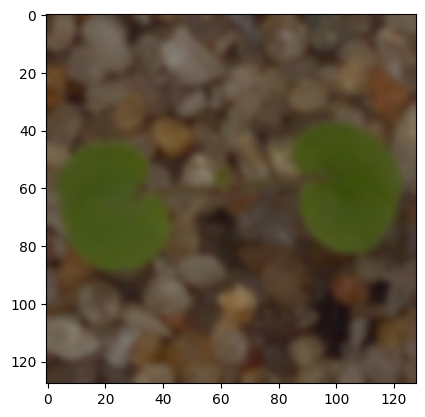

In [21]:
# Print the corresponding large image of Small Flower Cranesbill after all image processing has been applied:
plt.imshow(images_gb[0])

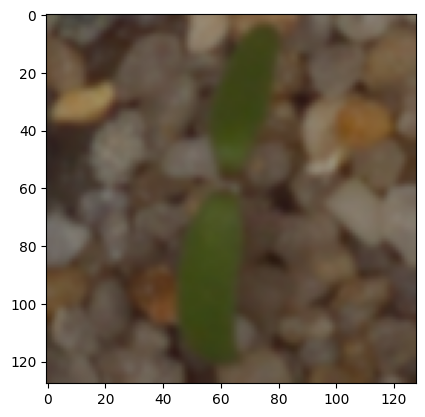

In [22]:
# Print the corresponding large image of Fat Hen after all image processing has been applied:
plt.imshow(images_gb[496])

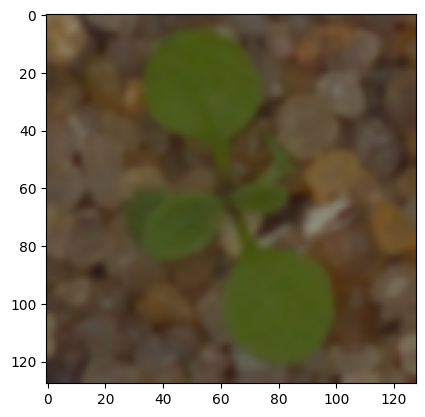

In [23]:
# Print the corresponding large image of Shepherds Purse after all image processing has been applied:
plt.imshow(images_gb[971])

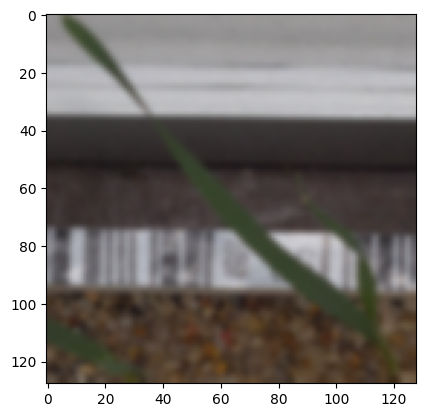

In [24]:
# Print  the corresponding large image of Common wheat after all image processing has been applied:
plt.imshow(images_gb[1202])

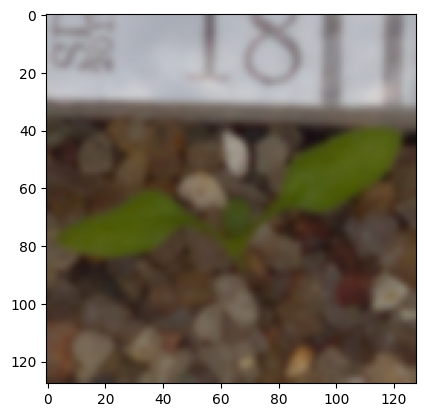

In [25]:
# print the corresponding large image of Common Chickweed after all image processing has been applied:
plt.imshow(images_gb[1423])

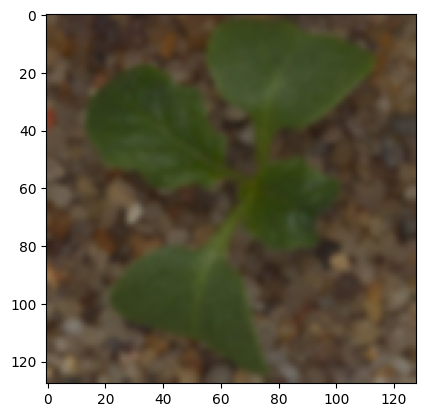

In [26]:
# Print the corresponding large image of Charlock after all image processing has been applied:
plt.imshow(images_gb[2034])

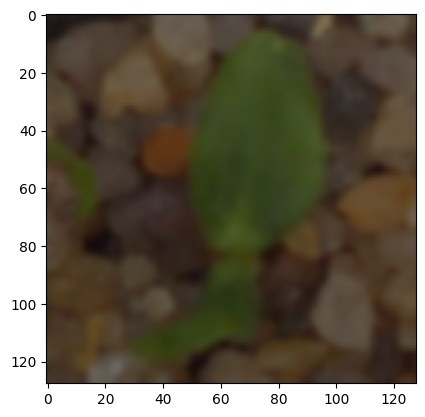

In [27]:
# Print the corresponding large image of Cleavers after all image processing has been applied:
plt.imshow(images_gb[2424])

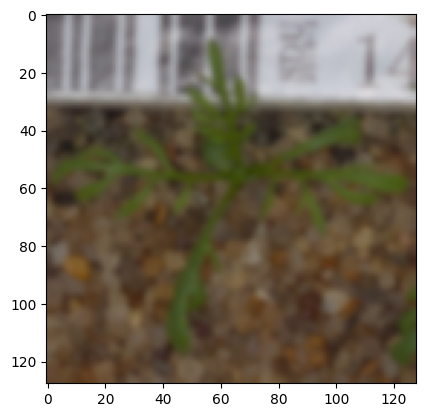

In [28]:
# Print the corresponding large image of Scentless Mayweed after all image processing has been applied:
plt.imshow(images_gb[2711])

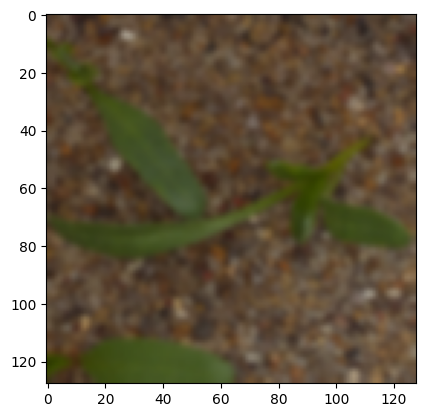

In [29]:
# Print the corresponding large image of Sugar beet after all image processing has been applied:
plt.imshow(images_gb[3227])

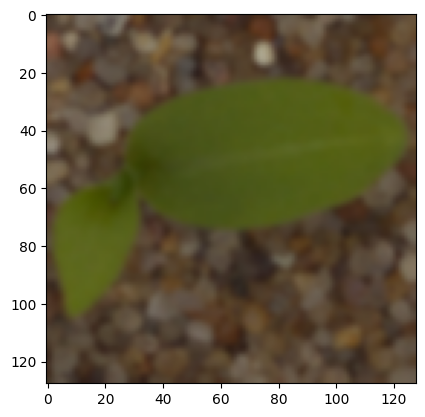

In [30]:
# Print the corresponding large image of Maize after all image processing has been applied:
plt.imshow(images_gb[3612])

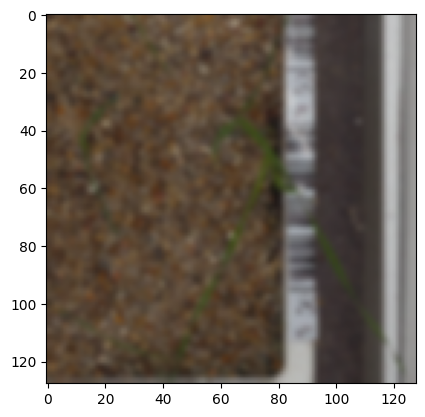

In [31]:
# Print the corresponding large image of Black grass after all image processing has been applied:
plt.imshow(images_gb[3833])

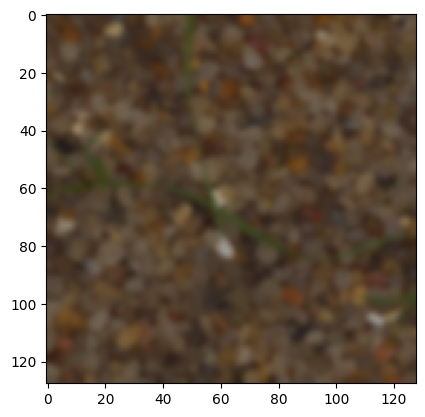

In [32]:
# Print the corresponding large image of Loose Silky-bent after all image processing has been applied:
plt.imshow(images_gb[4096])

### Comments On Images After Conversion To RGB and Gaussian Deblurring

* A number of the Black grass images were viewed and many of the images were of poor clarity both before conversion to RGB and Gaussian Deblurring and after those treatments were implemented.

* A number of the Loose Silky-bent images were viewed and many of the images were of poor clarity both before conversion to RGB and Gaussian Deblurring and after those treatments were implemented.

### Split Dataset

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=1,stratify=labels)

In [34]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, temporary and test

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=1,stratify=labels)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(3206, 128, 128, 3) (1069, 128, 128, 3) (475, 128, 128, 3)


In [35]:
# Print shape of target data
print(y_train.shape, y_val.shape, y_test.shape)

(3206, 1) (1069, 1) (475, 1)


In [36]:
# Determine distribution of target value in y_train
count = (y_train).value_counts(ascending = True)
print(count)
print('*'*10)
count = (y_train).value_counts(normalize = True, ascending = True)
print(count)

Label                    
Common wheat                 149
Maize                        149
Shepherds Purse              156
Black-grass                  178
Cleavers                     194
Sugar beet                   260
Charlock                     263
Fat Hen                      320
Small-flowered Cranesbill    335
Scentless Mayweed            348
Common Chickweed             412
Loose Silky-bent             442
dtype: int64
**********
Label                    
Common wheat                 0.046475
Maize                        0.046475
Shepherds Purse              0.048659
Black-grass                  0.055521
Cleavers                     0.060512
Sugar beet                   0.081098
Charlock                     0.082034
Fat Hen                      0.099813
Small-flowered Cranesbill    0.104492
Scentless Mayweed            0.108546
Common Chickweed             0.128509
Loose Silky-bent             0.137867
dtype: float64


* The y_train species distribution is consistent with the overall dataset.

In [37]:
# Determine distribution of target value in y_val
count = (y_val).value_counts(ascending = True)
print(count)
print('*'*10)
count = (y_val).value_counts(normalize = True, ascending = True)
print(count)

Label                    
Common wheat                  50
Maize                         50
Shepherds Purse               52
Black-grass                   59
Cleavers                      64
Sugar beet                    87
Charlock                      88
Fat Hen                      107
Small-flowered Cranesbill    111
Scentless Mayweed            116
Common Chickweed             138
Loose Silky-bent             147
dtype: int64
**********
Label                    
Common wheat                 0.046773
Maize                        0.046773
Shepherds Purse              0.048644
Black-grass                  0.055192
Cleavers                     0.059869
Sugar beet                   0.081384
Charlock                     0.082320
Fat Hen                      0.100094
Small-flowered Cranesbill    0.103835
Scentless Mayweed            0.108513
Common Chickweed             0.129093
Loose Silky-bent             0.137512
dtype: float64


* The species distribution in y_val is consistent with the overall dataset.

In [38]:
# Determine distribution of target value in y_test
count = (y_test).value_counts(ascending = True)
print(count)
print('*'*10)
count = (y_test).value_counts(normalize = True, ascending = True)
print(count)

Label                    
Common wheat                 22
Maize                        22
Shepherds Purse              23
Black-grass                  26
Cleavers                     29
Sugar beet                   38
Charlock                     39
Fat Hen                      48
Small-flowered Cranesbill    50
Scentless Mayweed            52
Common Chickweed             61
Loose Silky-bent             65
dtype: int64
**********
Label                    
Common wheat                 0.046316
Maize                        0.046316
Shepherds Purse              0.048421
Black-grass                  0.054737
Cleavers                     0.061053
Sugar beet                   0.080000
Charlock                     0.082105
Fat Hen                      0.101053
Small-flowered Cranesbill    0.105263
Scentless Mayweed            0.109474
Common Chickweed             0.128421
Loose Silky-bent             0.136842
dtype: float64


* The species distribution in y_test is consistent with the overall dataset

In [39]:
# Convert labels from names to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_e = enc.fit_transform(y_train)
y_val_e = enc.fit_transform(y_val)
y_test_e = enc.transform(y_test)

In [40]:
# Normalizing the image pixels to 0-1 by dividing the pixel values by 255
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [41]:
# Implement data augmentation for training data
generator = ImageDataGenerator(rotation_range = 20, fill_mode = 'nearest', zoom_range = 0.2,width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True)
generator.fit(X_train)

In [42]:
# Compute y_train class weights

from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
classes = np.array(labelList),
y = y_train.values.reshape(-1)
)
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7975124378109453,
 1: 0.8348958333333333,
 2: 1.7126068376068375,
 3: 1.7930648769574944,
 4: 0.6484627831715211,
 5: 1.0158428390367553,
 6: 1.377147766323024,
 7: 0.76772030651341,
 8: 1.0275641025641025,
 9: 1.7930648769574944,
 10: 1.500936329588015,
 11: 0.6044494720965309}

* The class weights are appropriate and will be used in model fitting.

## Model Images

* Accuracy will be the optimization metric for image classification.
* Precision, recall, and f1-score will also be considered.

### Build CNN Model 1



In [43]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [44]:
import random
np.random.seed(1) #for numpy
random.seed(1)
tf.random.set_seed(1) #for tensorflow

In [45]:
# Build CNN For Image Classification
model_1 = Sequential()

# First feature extraction layer
model_1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
# Add batch normalization to reduce overfitting
model_1.add(BatchNormalization())

# Second feature extraction layer
model_1.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
#  Add dropout to randomly switch off 50% neurons to reduce overfitting
model_1.add(Dropout(0.50))

# Third feature extraction layer
model_1.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Dropout(0.50))

# Fourth feature extraction layer
model_1.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Dropout(0.50))

# Fifth feature extraction layer
model_1.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2,2), padding = 'same'))

# Sixth feature extraction Layer
model_1.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
# Add batch normalization
model_1.add(BatchNormalization())

#Add flattening layer
model_1.add(Flatten())

# Add first fully connected layer
model_1.add(Dense(100, activation='relu'))
model_1.add(Dropout(0.25))

# Add second fully connected layer
model_1.add(Dense(100, activation='relu'))
model_1.add(Dropout(0.25))

# Add the output layer with 12 neurons and softmax activation function since this is a multi-class classification problem
model_1.add(Dense(12, activation='softmax'))

# Compile model
opt = Adam(learning_rate = 0.0003)
model_1.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                        

###  Fitting the model on the train data

* Initially used callbacks with objective of halting execution and saving the best model when validation loss stopped decreasing.  
* Removed the callbacks because the initial low rate of validation loss decrease caused model training to terminate prematurely.
* The epochs parameter was varied and set at the optimum value for model_1.
* Class weights are used to compensate for the imbalanced dataset.
    

In [46]:

history_1 = model_1.fit(
            X_train_normalized, y_train_e,
            epochs=50,
            validation_data = (X_val_normalized, y_val_e),
            shuffle=True,
            batch_size=64,
            verbose=2,
            class_weight = class_weights
)

Epoch 1/50
51/51 - 24s - loss: 2.7397 - accuracy: 0.1953 - val_loss: 3.4736 - val_accuracy: 0.1375 - 24s/epoch - 480ms/step
Epoch 2/50
51/51 - 6s - loss: 2.2252 - accuracy: 0.3175 - val_loss: 6.8833 - val_accuracy: 0.1375 - 6s/epoch - 122ms/step
Epoch 3/50
51/51 - 6s - loss: 1.9540 - accuracy: 0.3955 - val_loss: 9.8361 - val_accuracy: 0.1375 - 6s/epoch - 120ms/step
Epoch 4/50
51/51 - 6s - loss: 1.7309 - accuracy: 0.4492 - val_loss: 11.0233 - val_accuracy: 0.1375 - 6s/epoch - 119ms/step
Epoch 5/50
51/51 - 6s - loss: 1.5730 - accuracy: 0.4956 - val_loss: 10.4299 - val_accuracy: 0.1375 - 6s/epoch - 117ms/step
Epoch 6/50
51/51 - 6s - loss: 1.4474 - accuracy: 0.5253 - val_loss: 11.6836 - val_accuracy: 0.1375 - 6s/epoch - 119ms/step
Epoch 7/50
51/51 - 6s - loss: 1.3112 - accuracy: 0.5658 - val_loss: 13.1681 - val_accuracy: 0.1375 - 6s/epoch - 118ms/step
Epoch 8/50
51/51 - 6s - loss: 1.2249 - accuracy: 0.5995 - val_loss: 12.8091 - val_accuracy: 0.1375 - 6s/epoch - 123ms/step
Epoch 9/50
51/51 

### Model Evaluation

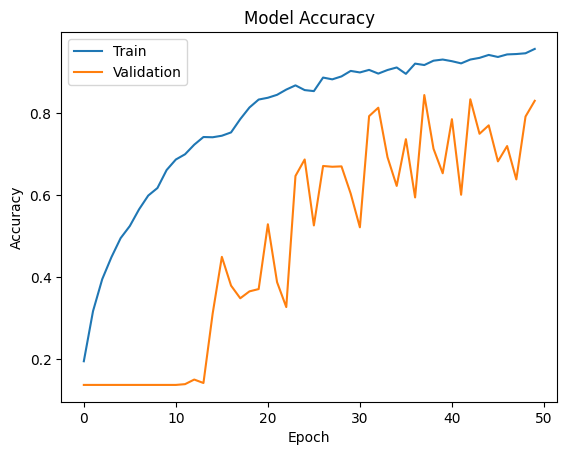

In [47]:
# Plot accuracy vs epoch
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Comments On Model Performance and Configuration

* Optimization of data augmentation settings improved model accuracy.
* Dropout and backwardation were used to reduce the overfitting concern.
* Different numbers of neurons in the fully connected layers were tried.
* Dropout settings were varied and adding dropout to the fully connected layers significantly improved accuracy, recall, precision and F1.
* A trial of the SGD optimizer was conducted, however Adam performed better.
* The Adam optimizer learning rate was lowered from the default value with improved performance.
* Model_1 has 6,489,108 total parameters and 6,487,956 trainable parameters.




### Evaluate Model Predictions

In [48]:
# Calculate model 1 overall accuracy for test data
accuracy = model_1.evaluate(X_test_normalized, y_test_e, verbose=2)

15/15 - 2s - loss: 0.7959 - accuracy: 0.8126 - 2s/epoch - 108ms/step


In [49]:
# Obtain model_1 output as probablities for each category
y_pred = model_1.predict(X_test_normalized)

15/15 [==============================] - 0s 14ms/step


### Plot Confusion Matrix


* The `argmax()`function obtains the maximum value over each category on both y_test_encoded and y_pred and obtains their respective classes.





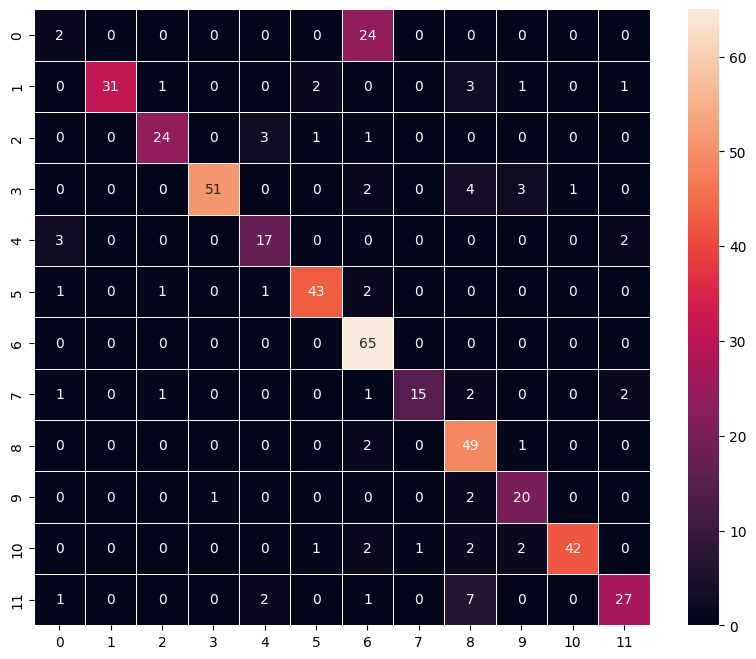

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix


# Obtaining the categorical values from y_test_e and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_e,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Comments on Confusion Matrix
* Approximately 96% of the Black-grass images were mis-classified to be Loose Silky-bent.
* Mis-classification of Black-grass images accounted for 26% of the 96 images in the test dataset which were mis-classified.
* 11% of the Common Chickweed images were mis-classified as Scentless Mayweed.
* 8% of the Fat Hen was mis-classified as Loose Silky-bent
* 10% of the Fat Hen was mis-classified as Scentless Mayweed.
* 15% of the Charlock was mis-classified as Scentless Mayweed.
* 32% of the Maize was mis-classified as Sugar beet.

In [52]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_arg, y_pred_arg, output_dict =True))

{'0': {'precision': 0.25, 'recall': 0.07692307692307693, 'f1-score': 0.11764705882352941, 'support': 26}, '1': {'precision': 1.0, 'recall': 0.7948717948717948, 'f1-score': 0.8857142857142858, 'support': 39}, '2': {'precision': 0.8888888888888888, 'recall': 0.8275862068965517, 'f1-score': 0.8571428571428572, 'support': 29}, '3': {'precision': 0.9807692307692307, 'recall': 0.8360655737704918, 'f1-score': 0.9026548672566372, 'support': 61}, '4': {'precision': 0.7391304347826086, 'recall': 0.7727272727272727, 'f1-score': 0.7555555555555555, 'support': 22}, '5': {'precision': 0.9148936170212766, 'recall': 0.8958333333333334, 'f1-score': 0.9052631578947369, 'support': 48}, '6': {'precision': 0.65, 'recall': 1.0, 'f1-score': 0.787878787878788, 'support': 65}, '7': {'precision': 0.9375, 'recall': 0.6818181818181818, 'f1-score': 0.7894736842105263, 'support': 22}, '8': {'precision': 0.7101449275362319, 'recall': 0.9423076923076923, 'f1-score': 0.8099173553719008, 'support': 52}, '9': {'precisio

### Classification Report Comments

* Model_1 Overall Performance:

* The overall accuracy is 0.80.
* The overall weighted average precision is 0.83.
* The overall weighted average recall is 0.80.
* The overall weighted average f1-score is 0.78.

* Performance For Identification of Individual Species:

* Black-grass (confusion matrix index 0) - The 0.50 precision is low, and the 0.04 recall, and 0.07 f1-score are extremely low. This is attributed to the observed low image clarity for this species. This species was underrepresented in the dataset.

* Charlock (confusion matrix index 1) - The precision is 1.0, recall is 0.69, and the f1-score is 0.82. These are acceptable metrics and proportion of images for this species was appropriate for a dataset with 12 categories.

* Cleavers (confusion matrix index 2) - The precision is 0.96, recall is 0.79, and f1-score is 0.87. This species was underrepresented in the dataset.

* Common Chickweed (confusion matrix index 3) - The precision is 0.98, recall is 0.84 and f1-score is 0.90. This species is overrepresented in the dataset.

* Common wheat (confusion matrix index 4) - The precision is 0.90, recall is 0.86 and the f1-score is 0.88. This species was underrepresented in the dataset,

* Fat Hen (confusion matrix index 5) - The precision is 0.91, recall is 0.81, and f1-score is 0.86. This species is overrepresented in the dataset.

* Loose Silky-bent (confusion marix index 6) - The precision is 0.65, recall is 0.98 and f1-score is 0.78. This species is overrepresented in the dataset.

* Maize (confusion matrix index 7) - The precision is 0.93, recall is 0.64, and f1-score is 0.76. This species is underrepresented in the dataset.

* Scentless Mayweed (confusion matrix index 8) - The precision is 0.59, recall is 0.98, and f1-score is 0.73.  This species is overrepresented in the dataset.

* Shepherds Purse (confusion matrix index 9) - The precision is 0.88, recall is 0.61, and f1-score is 0.71.  This species is underrepresented in the dataset.

* Small-flowered Cranesbill (confusion matrix index 10) - The precision is 0.93, recall is 0.86, and f1-score is 0.90. This species is overrepresented in the dataset.

* Sugar beet (confusion matrix index 11) - The precision is 0.77, the recall is 0.87, and f1-score is 0.81. The representation of this species in the dataset is appropriate for a dataset with 12 categories.

### Model_1 Findings and Planned Changes For Model_2

* Model_1 Overall Performance:

* Overall accuracy - 0.80
* Overall weighted average precision - 0.83
* Overall weighted average recall - 0.80
* Overall weighted average f1-score - 0.78

* Almost all of the Black grass was mis-classified to Loose Silky-bent
* There was a concern with other species being mis-classified to either Loose Silky-bent or Scentless Mayweed.
* 32% of the Maize was mis-classified as Sugar beet

* Planned Model Configuration Changes:

* Model_2 will have two filters per feature extraction layer rather than one as Model_1 has.
* Model_2 will utilize a lower dropout fraction in the feature extraction layers.
* Model_2 will have an added fully connected layer (total of 3) upstream of the output layer.
* It is expected that Model_2 will have a significantly greater number of total parameters and trainable parameters than Model_1.





### CNN Model 2



In [53]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [54]:
import random
np.random.seed(1) #for numpy
random.seed(1)
tf.random.set_seed(1) #for tensorflow

In [55]:
# Build CNN For Image Classification
model_2 = Sequential()

# First feaTure extraction layer
model_2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
model_2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
# Add 15% dropout to randomly turn off 15% neurons to prevent overfitting
model_2.add(Dropout(0.15))

# Second feature extraction layer
model_2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
model_2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
# Add batch normalization
model_2.add(BatchNormalization())

# Third feature extraction Layer
model_2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
model_2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
# Adding 15% dropout to randomly turn off 20% neurons to prevent overfitting
model_2.add(Dropout(0.15))

# Fourth feature extraction layer
model_2.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
model_2.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
# Add batch normalization
model_2.add(BatchNormalization())

# Fifth feature extraction layer
model_2.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
model_2.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same',
                 activation ='relu', input_shape = (128,128,3)))
# Add max pooling
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
# Add batch normalization
model_2.add(BatchNormalization())

#Add flattening layer
model_2.add(Flatten())

# First fully connected layer
model_2.add(Dense(100, activation='relu'))
model_2.add(Dropout(0.25))

# Second fully connected layer
model_2.add(Dense(100, activation='relu'))
model_2.add(Dropout(0.25))

# Third fully connected layer
model_2.add(Dense(100, activation='relu'))

# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model_2.add(Dense(12, activation='softmax'))

# Compile model
opt = Adam(learning_rate = 0.0003)
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                        

###  Fit Model on Training Data

* Initially used callbacks to halt execution and save the best model when validation loss stopped decreasing.  
* Removed the callbacks because the initial low rate of validation loss decrease caused model training to terminate prematurely.
* The epochs parameter was varied and set to the optimum value.
* Class weights were used to compensate for the imbalanced dataset.
    

In [56]:

history_2 = model_2.fit(
            X_train_normalized, y_train_e,
            epochs=45,
            validation_data = (X_val_normalized, y_val_e),
            shuffle=True,
            batch_size=64,
            verbose=2,
            class_weight = class_weights
)

Epoch 1/45
51/51 - 31s - loss: 2.9400 - accuracy: 0.1588 - val_loss: 2.6061 - val_accuracy: 0.1375 - 31s/epoch - 615ms/step
Epoch 2/45
51/51 - 15s - loss: 2.2781 - accuracy: 0.3110 - val_loss: 3.0683 - val_accuracy: 0.1375 - 15s/epoch - 295ms/step
Epoch 3/45
51/51 - 15s - loss: 1.7418 - accuracy: 0.4448 - val_loss: 7.5993 - val_accuracy: 0.1375 - 15s/epoch - 291ms/step
Epoch 4/45
51/51 - 15s - loss: 1.4748 - accuracy: 0.5147 - val_loss: 12.8602 - val_accuracy: 0.1375 - 15s/epoch - 290ms/step
Epoch 5/45
51/51 - 15s - loss: 1.3963 - accuracy: 0.5371 - val_loss: 11.2431 - val_accuracy: 0.1375 - 15s/epoch - 295ms/step
Epoch 6/45
51/51 - 15s - loss: 1.2452 - accuracy: 0.5708 - val_loss: 15.8472 - val_accuracy: 0.1375 - 15s/epoch - 296ms/step
Epoch 7/45
51/51 - 15s - loss: 1.1683 - accuracy: 0.6032 - val_loss: 13.5708 - val_accuracy: 0.1375 - 15s/epoch - 297ms/step
Epoch 8/45
51/51 - 15s - loss: 1.0545 - accuracy: 0.6369 - val_loss: 10.0203 - val_accuracy: 0.1375 - 15s/epoch - 292ms/step
Epo

### Model Evaluation

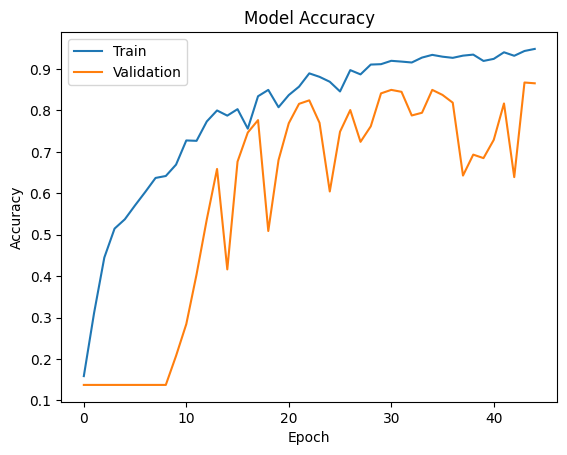

In [57]:
# Plot model accuracy vs. epoch
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Comments On Model Performance and Configuration

* Optimization of data augmentation settings improved model accuracy.
* Dropout and batch normalization were used to reduce the overfitting concern.
* Multiple convolutions were performed in each feature extraction layer.
* The number of fully connected layers as well as number of neurons in each layer were varied.
* The implementation of dropout in the fully connected layers performed slightly better than batch normalization.
* The Adam optimizer was found to perform better than the SGD optimizer.
* The Adam optimizer learning rate was lowered below the default value.
* Model_2 has 10,250,312 total parameters and 10,248,008 trainable parameters.






### Evaluate Model Predictions

In [58]:
# Calculate model_2 overall accuracy for test data
accuracy = model_2.evaluate(X_test_normalized, y_test_e, verbose=2)

15/15 - 3s - loss: 0.4785 - accuracy: 0.8716 - 3s/epoch - 193ms/step


In [59]:
# Obtain model_2 output as probablities for each category
y_pred = model_2.predict(X_test_normalized)

15/15 [==============================] - 1s 31ms/step


### Plot Confusion Matrix

* The argmax() function obtains the maximum value over each category on both y_test_e and y_pred and obtains their respective classes.





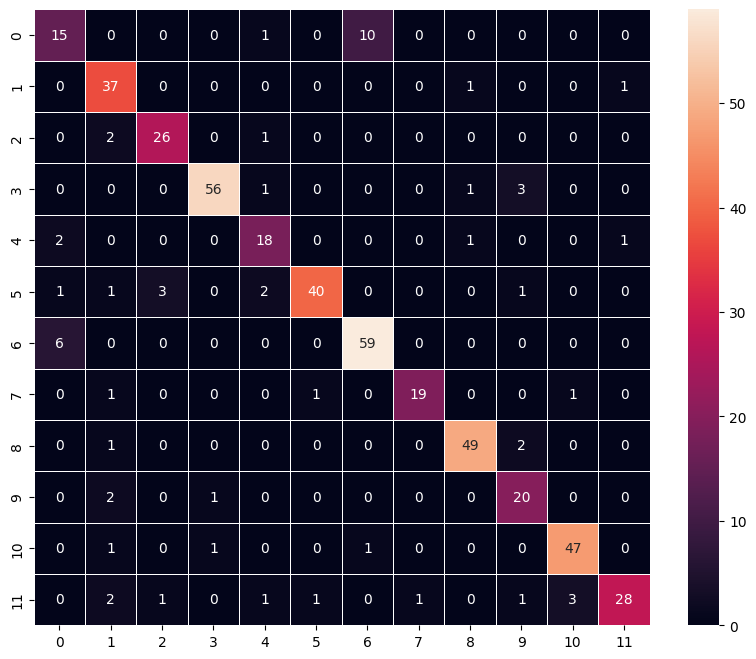

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_e,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Comments on Confusion Matrix
* Approximately 46% of the Black-grass images were mis-classified to be Loose Silky-bent.
* The total of 12 Black-grass images which were misclassified accounted of 29% of the total of 42 test set images which were misclassified.
* Approximately 17% of the Scentless Mayweed was mis-classified as Shepherds Purse.
* Approximately 10% of the charlock was misclassified as Cleavers.
* Approximately 8% of the Silky-bent was mis-classified as Black grass



### Print Classification Report


In [61]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60        26
           1       0.79      0.95      0.86        39
           2       0.87      0.90      0.88        29
           3       0.97      0.92      0.94        61
           4       0.75      0.82      0.78        22
           5       0.95      0.83      0.89        48
           6       0.84      0.91      0.87        65
           7       0.95      0.86      0.90        22
           8       0.94      0.94      0.94        52
           9       0.74      0.87      0.80        23
          10       0.92      0.94      0.93        50
          11       0.93      0.74      0.82        38

    accuracy                           0.87       475
   macro avg       0.86      0.85      0.85       475
weighted avg       0.88      0.87      0.87       475



### Classification Report Comments:

* Model_2 Overall Performance:

* Model overall accuracy is 0.86.
* Model weighted average precision is 0.87.
* Model weighted average recall is 0.86.
* Model weighted average f1-score is 0.86

* Performance For Identification Of Individual Species:

* Black-grass (confusion matrix index 0) - The precision of 0.62, recall of 0.50, and f1-score of 0.55 are all low. This is attributed to the observed relatively low image clarity. This species was underrepresented in the dataset.

* Charlock (confusion matrix index 1) - The precision is 0.91, recall is 0.81, and f1-score is 0.86. The number of images of this species in the dataset is approriate for a classification with 12 categories.

* Cleavers (confusion matrix index 2) - The precision is 0.80, recall is 0.97, and f1-score is 0.88. This species is underrepresented in the dataset.

* Common Chickweed (confusion matrix index 3) - The precision is 0.92, recall is 0.95, and f1-score is 0.94. This species is overrepresented in the dataset.

* Common wheat (confusion matrix index 4) - The precision is 0.83, recall is 0.91, and f1-score is 0.87. This species is underrepresented in the dataset.

* Fat Hen (confusion matrix index 5) - The precision is 0.90, recall is 0.90, and f1-score is 0.90. This species is overrepresented in the dataset.

* Loose Silky-bent (confusion matrix index 6) - The precision is 0.81, recall is 0.92, and f1-score is 0.86. This species is overrepresented in the dataset.

* Maize (confusion matrix index 7) - The precision is 1.00, recall is 0.86, and f1-score is 0.93.  This species is underrepresented in the dataset.

* Scentless Mayweed (confusion matrix index 8) - The precision is 0.97, recall is 0.75, and f1-score is 0.85. This species is overrepresented in the dataset.

* Shepherds Purse (confusion matrix index 9) - The precision is 0.64, recall is 0.91, f1-score is 0.75. This species is underrepresented in the dataset.

* Small-flowered Cranesbill (confusion matrix index 10) - The precision is 0.98, recall is 0.94, and f1-score is 0.96. This species is overrepresented in the dataset.

* Sugar beet (confusion matrix index 11) - The precision is 0.86, recall is 0.79, and f1-score is 0.82. The species is represented in the dataset in an amount appropriate for a 12 category classification problem.






## Comparison Of Model_1 and Model_2 Overall Performance

* Model_2 outperforms Model_1 in all metrics:
      
* Accuracy - Model_1 accuracy is 0.80, Model_2 accuracy is 0.86

* Precision - Model_1 precision is 0.83, Model_2 precision is 0.87

* Recall - Model_1 recall is 0.80, Model_2 recall is 0.86

* F1-score - Model_1 f1-score is 0.78, Model_2 f1-score is 0.86

* The better performing model has a greater number of total and trainable parameters:

* Model_1: Total parameters - 6,489,108

* Model_1: Trainable parameters - 6,487,956

* Model_2: Total parameters - 10,250,312

* Model_2: Trainable parameters - 10,248,008




## Key Findings and Conclusions

* Model_2 had a significantly greater number of trainable parameters and exhibited significantly better performance and is the model that should be used.

* Several permutations of data augmentation parameters were used and optimal settings for these parameters resulted in significantly improved prediction accuracy.

* Adding dropout to the fully connected layers and increasing the number of fully connected layers improved performance.

* Increasing the number of filters per feature extraction layer from one to two improved performance.

* Many of the Black grass images were of very poor quality. Replacing the poor quality images with a greater quantity of better quality images should result in significantly better prediction accuracy.

* There was a significant difficulty in distinguishing between Black grass and Loose Silky-bent. Approximately 46% of the Black grass was mis-classified as Loose Silky-bent and approximately 8% of the Loose Silky-bent was mis-classified as Black grass.

* There was a tendency to mis-classify species which had a greater population to species which were underrepresented. Approximately 17% of the Scentless Mayweed was mis-classified as Shepherds Purse. Approximately 10% of Charlock was mis-classified as Cleavers.

* The following species were underrepresented in the dataset: Common wheat, Maize, Shepherd's Purse, Black grass, and Cleavers. Adding additional images of these species should improve the prediction quality.

* Class weights were calculated and were used in model fitting. Oversampling and undersampling were considered but not implemented in the study as this was not part of the scoring rubric.
  